# Review Flagged CARS Images

This notebook helps in reviewing images that were flagged as potential outliers by the `scripts/validate_dataset.py` script.

**Instructions:**
1. Ensure you have run `python scripts/validate_dataset.py` and it has generated a report in `data/data_validation_reports/`.
2. Update `REPORT_PATH` below if your report has a different name or location.
3. Run the cells to load the report and display the flagged images.
4. Based on your review, you can compile a list of images to exclude from training.
5. The final cell can be used to save a new CSV containing only the valid (non-excluded) images.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import cv2 # OpenCV for image loading
import os
from IPython.display import Image, display, HTML
import numpy as np

## Configuration

In [2]:
# Path to the CSV report generated by validate_dataset.py
# This path is relative to the project root (cars_gen_advanced/)
REPORT_PATH = "../data/data_validation_reports/dataset_validation_report.csv"
CLEANED_REPORT_PATH = "../data/data_validation_reports/dataset_validation_report_cleaned.csv"

# Base directory for resolving relative image paths in the report
# This should be the root of your project (cars_gen_advanced/)
PROJECT_ROOT = ".." # Assuming the notebook is in 'notebooks/' directory

# Number of images to display at once (or set to None to display all)
MAX_IMAGES_TO_DISPLAY = 50 

## Load the Validation Report

In [3]:
try:
    report_df = pd.read_csv(REPORT_PATH)
    print(f"Successfully loaded report from: {REPORT_PATH}")
    print(f"Total entries in report: {len(report_df)}")
except FileNotFoundError:
    print(f"Error: Report file not found at {REPORT_PATH}. Please run validate_dataset.py first.")
    report_df = pd.DataFrame() # Create empty df to avoid further errors

if not report_df.empty:
    # Filter for flagged images
    flagged_df = report_df[report_df['is_potential_outlier'] == True].copy()
    print(f"Number of potentially flagged images: {len(flagged_df)}")
    
    # Convert relative paths from report to absolute paths for display
    flagged_df.loc[:, 'full_path'] = flagged_df['path'].apply(lambda x: os.path.join(PROJECT_ROOT, x) if PROJECT_ROOT != '.' else x)
    flagged_df.loc[:, 'full_path'] = flagged_df['full_path'].apply(os.path.normpath)
    
    print("\nFirst 5 flagged entries (if any):")
    display(flagged_df.head())

Successfully loaded report from: ../data/data_validation_reports/dataset_validation_report.csv
Total entries in report: 450
Number of potentially flagged images: 11

First 5 flagged entries (if any):


,path,mean_intensity,std_intensity,pixel_variance,laplacian_variance,shannon_entropy,is_mostly_flat,class_label,is_potential_outlier,reasons_for_flagging,full_path
23,data/raw_thyroid_cars/healthy/normal_210.tif,602.28125,867.82430,753119.00,10806611.0,10.073900,False,healthy,True,"BrightnessOutlier (602.28 not in [0.99, 446.91...",../data/raw_thyroid_cars/healthy/normal_210.tif
27,data/raw_thyroid_cars/healthy/normal_166.tif,455.38770,785.23517,616594.30,7001564.5,9.052985,False,healthy,True,"BrightnessOutlier (455.39 not in [0.99, 446.91...",../data/raw_thyroid_cars/healthy/normal_166.tif
46,data/raw_thyroid_cars/healthy/normal_20.tif,667.95746,1935.88820,3747663.00,29392766.0,7.328777,False,healthy,True,"BrightnessOutlier (667.96 not in [0.99, 446.91...",../data/raw_thyroid_cars/healthy/normal_20.tif
57,data/raw_thyroid_cars/healthy/normal_21.tif,343.61050,875.63490,766736.44,14033105.0,7.704297,False,healthy,True,"ContrastOutlier (875.63 not in [0.10, 685.27])",../data/raw_thyroid_cars/healthy/normal_21.tif
91,data/raw_thyroid_cars/healthy/normal_129.tif,558.02527,841.32750,707832.00,9821682.0,9.672909,False,healthy,True,"BrightnessOutlier (558.03 not in [0.99, 446.91...",../data/raw_thyroid_cars/healthy/normal_129.tif


## Display Flagged Images

Displaying up to 11 flagged images:



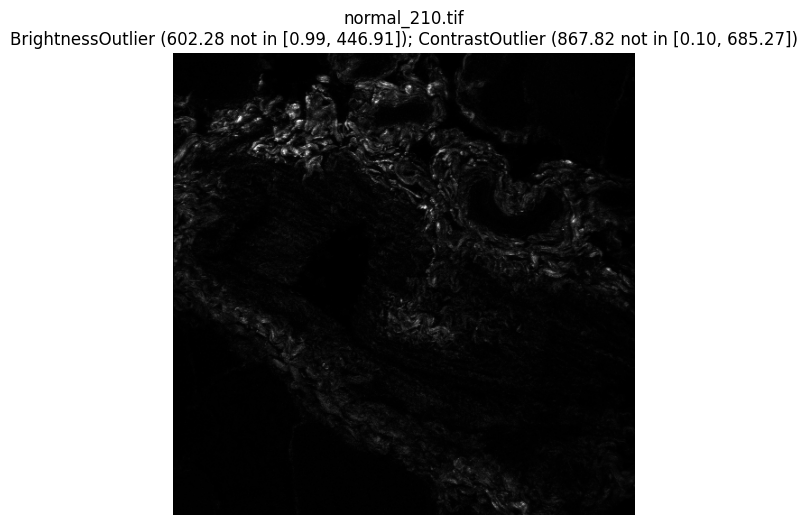

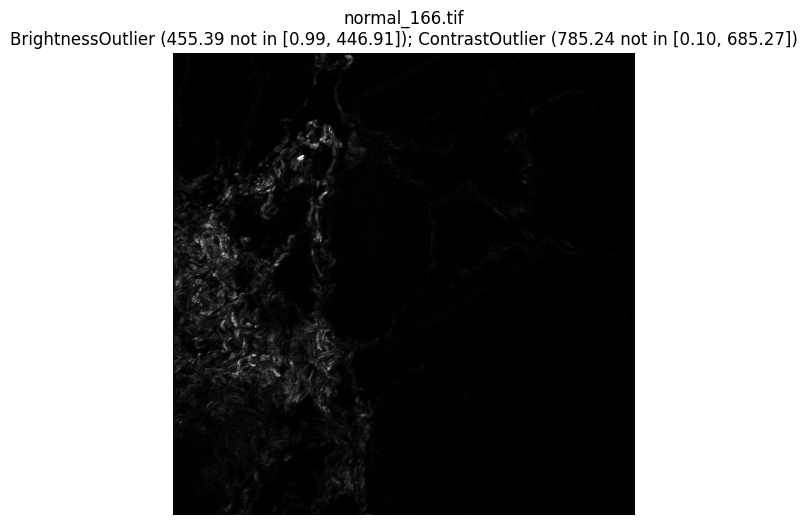

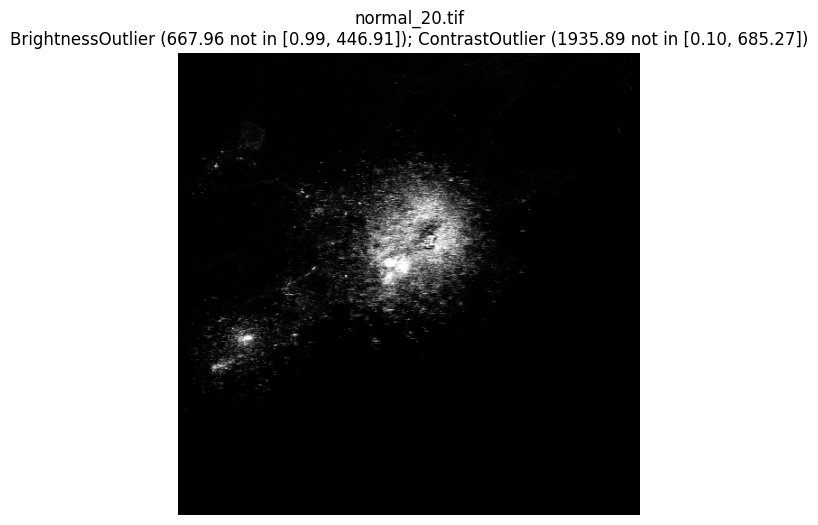

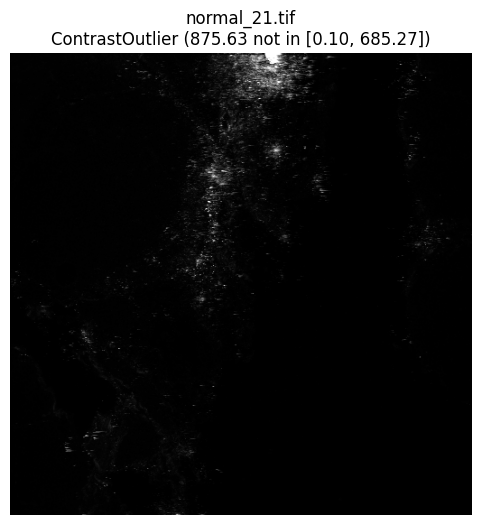

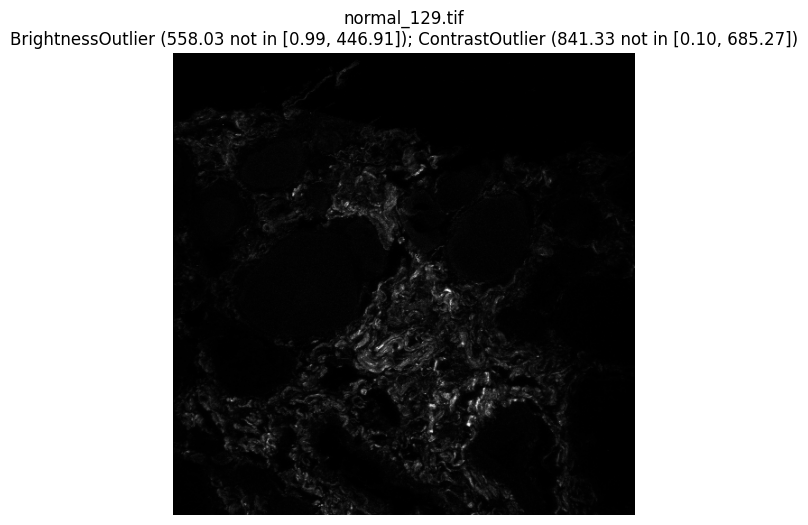

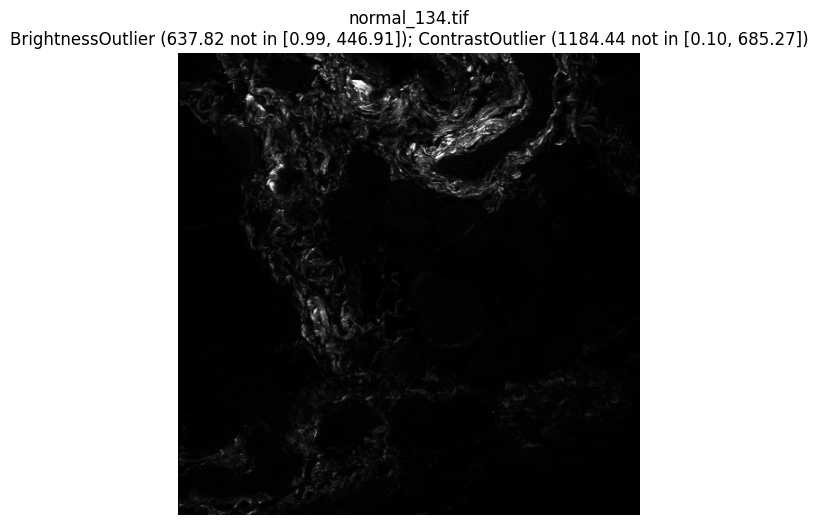

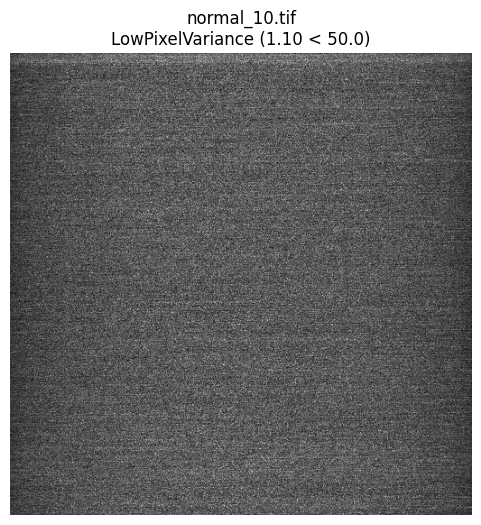

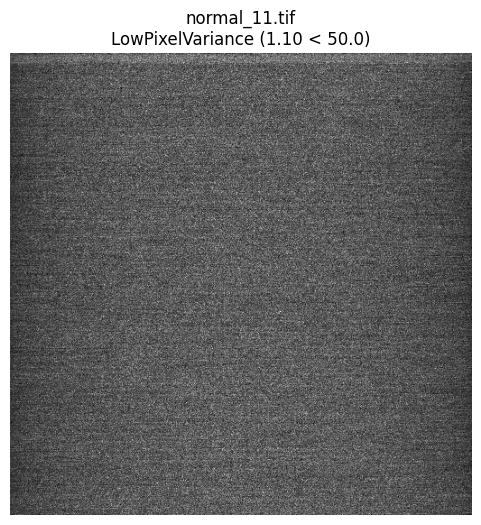

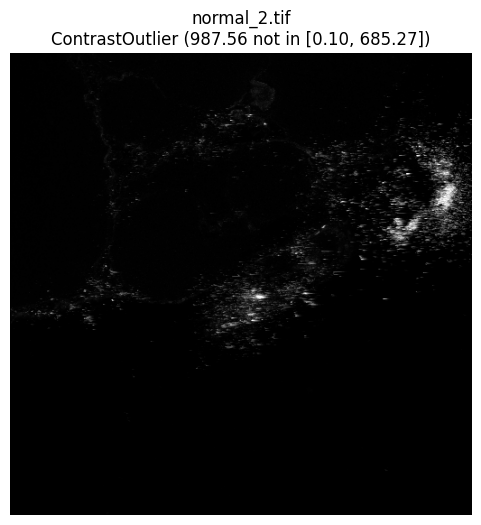

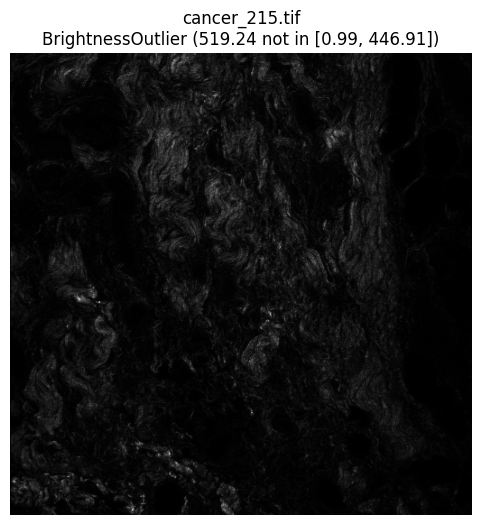

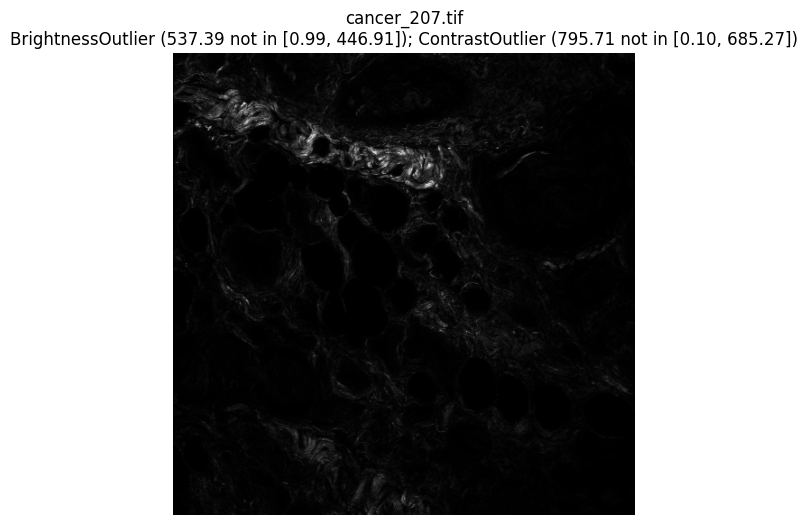

In [4]:
def display_flagged_images(df, max_images=None):
    if df.empty:
        print("No flagged images to display.")
        return

    num_to_display = len(df) if max_images is None else min(len(df), max_images)
    
    if num_to_display == 0:
        print("No flagged images to display (after MAX_IMAGES_TO_DISPLAY limit). ")
        return
        
    print(f"Displaying up to {num_to_display} flagged images:\n")

    for index, row in df.head(num_to_display).iterrows():
        image_path = row['full_path']
        reasons = row['reasons_for_flagging']
        class_label = row.get('class_label', 'N/A') # Get class label if available

        display(HTML(f"<h3>Image: {os.path.basename(image_path)} (Class: {class_label})</h3>"))
        display(HTML(f"<p><b>Full Path:</b> {image_path}</p>"))
        display(HTML(f"<p><b>Reasons for flagging:</b> {reasons}</p>"))
        
        if os.path.exists(image_path):
            # Load with OpenCV to handle TIFF and convert to displayable format if needed
            img = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
            if img is not None:
                # For UINT16, normalize to 0-255 for display with matplotlib
                if img.dtype == np.uint16:
                    img_display = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
                elif img.dtype == np.uint8:
                    img_display = img
                else: # Other types, try to convert
                    try:
                        img_display = img.astype(np.uint8)
                    except:
                        print(f"Could not convert image {os.path.basename(image_path)} dtype {img.dtype} to uint8 for display.")
                        continue
                
                plt.figure(figsize=(6, 6))
                if img_display.ndim == 2:
                    plt.imshow(img_display, cmap='gray')
                else: # If it's somehow color, display as is
                    plt.imshow(cv2.cvtColor(img_display, cv2.COLOR_BGR2RGB) if img_display.shape[-1] == 3 else img_display)
                plt.title(f"{os.path.basename(image_path)}\n{reasons}")
                plt.axis('off')
                plt.show()
            else:
                display(HTML(f"<p style='color:red;'>Error: Could not load image: {image_path}</p>"))
        else:
            display(HTML(f"<p style='color:red;'>Error: Image file not found at resolved path: {image_path}</p>"))
        display(HTML("<hr>"))

if not report_df.empty and not flagged_df.empty:
    display_flagged_images(flagged_df, MAX_IMAGES_TO_DISPLAY)
elif not report_df.empty and flagged_df.empty:
    print("No images were flagged as potential outliers in the report.")

## Create Cleaned Dataset Report

After reviewing the images, specify the paths (as they appear in the 'path' column of the CSV) of the images you want to exclude. This cell will then create a new CSV file containing only the valid images.

In [5]:
# --- User Input: Specify images to exclude ---
# Add the 'path' values from the CSV for images you want to exclude.
# Example: images_to_exclude = [
#    "data/raw_thyroid_cars/healthy/normal_10.tif", 
#    "data/raw_thyroid_cars/healthy/normal_11.tif"
# ]
# Assuming 'normal_10.tif' and 'normal_11.tif' are in the 'healthy' subdirectory.
# Adjust the paths if they are in 'cancerous' or have different extensions.

images_to_exclude = [
    "data/raw_thyroid_cars/healthy/normal_10.tif", # Replace with actual filename if different, e.g. healthy_10.tif
    "data/raw_thyroid_cars/healthy/normal_11.tif"  # Replace with actual filename if different, e.g. healthy_11.tif
]

if report_df.empty:
    print("Original report DataFrame is empty. Cannot create a cleaned report.")
else:
    print(f"Original number of images in report: {len(report_df)}")
    
    # Ensure the 'path' column exists
    if 'path' not in report_df.columns:
        print("Error: 'path' column not found in the report DataFrame.")
    else:
        # Filter out the excluded images
        cleaned_df = report_df[~report_df['path'].isin(images_to_exclude)].copy()
        
        print(f"Number of images to exclude: {len(images_to_exclude)}")
        print(f"Number of images after exclusion: {len(cleaned_df)}")
        
        # Save the cleaned DataFrame to a new CSV file
        try:
            cleaned_df.to_csv(CLEANED_REPORT_PATH, index=False)
            print(f"Successfully saved cleaned report to: {CLEANED_REPORT_PATH}")
            print("This cleaned report can now be used as the input for your DataModule.")
        except Exception as e:
            print(f"Error saving cleaned report: {e}")
        
        # Display the first few rows of the cleaned dataframe
        print("\nFirst 5 entries of the cleaned report (if any):")
        display(cleaned_df.head())

Original number of images in report: 450
Number of images to exclude: 2
Number of images after exclusion: 448
Successfully saved cleaned report to: ../data/data_validation_reports/dataset_validation_report_cleaned.csv
This cleaned report can now be used as the input for your DataModule.

First 5 entries of the cleaned report (if any):


,path,mean_intensity,std_intensity,pixel_variance,laplacian_variance,shannon_entropy,is_mostly_flat,class_label,is_potential_outlier,reasons_for_flagging
0,data/raw_thyroid_cars/healthy/normal_164.tif,198.13864,150.727080,22718.6520,367931.400,7.470610,False,healthy,False,NaN
1,data/raw_thyroid_cars/healthy/normal_19.tif,127.29755,28.288641,800.2472,49722.934,3.516744,False,healthy,False,NaN
2,data/raw_thyroid_cars/healthy/normal_170.tif,349.50850,675.990360,456963.0000,5331624.500,8.450000,False,healthy,False,NaN
3,data/raw_thyroid_cars/healthy/normal_31.tif,214.21881,148.356750,22009.7270,406427.970,7.745707,False,healthy,False,NaN
4,data/raw_thyroid_cars/healthy/normal_158.tif,220.53839,269.858220,72823.4600,1080607.400,7.721477,False,healthy,False,NaN


## Next Steps

After reviewing the images:
1. Create a list of image paths (the 'path' column from the CSV, which is relative to the project root) that you want to definitively exclude from training.
2. You can then use this list to filter your dataset when creating DataLoaders for training your generative models.